# Image Segmentation of Spiral Galaxies

This notebook provides a detailed insight into the process that goes into the segmentation of spiral arms from images of spiral galaxies. This notebook accompanies the final year research project I completed for my Masters Degree in Professional Engineering (Software) at University of WA. The dataset used for this notebook is adapted from images retrieved from the 2nd public data release from the HSC data archive system, which is operated by Subaru Telescope and Astronomy Data Center at National Astronomical Observatory of Japan and classification of spiral galaxies from this dataset was achieved by [Tadaki et al.](https://arxiv.org/pdf/2006.13544.pdf) and all image content is a product of their work. You can register to access the HSC Data [here](https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/).

## [1] Install Dependencies

Here we will run the imports for packages that are used commonly throughout the notebook. Any other required packages will be imported within the code cell that they are required.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## [2] Data Pre-Processing

This section covers the functionality used to process the data prior to it being used in training the segmentation model. These functions take the images from the dataset (in the format of `.jpg` and `.tif` files) to a data format that is usable by the Tensorflow Keras API. To achieve a concise pipeline, a Keras Sequence class is used to load and vectorize the data before training the model.

### Configure Location of Data and Training Parameters

In [79]:
images_dir = '/kaggle/input/galaxy-segmentation-set-1/images'
masks_dir = '/kaggle/input/galaxy-segmentation-set-1/masks_png'
img_size = (64, 64)

testing_ratio = 0.15 # ratio of dataset to be used for testing
batch_size = 32 # batch size after augmentation

### Load Dataset and Split Into Subsets

In [121]:
import os
from tensorflow.keras.utils import image_dataset_from_directory, split_dataset

images_ds = image_dataset_from_directory(images_dir, 
                                         labels=None, 
                                         color_mode='grayscale', 
                                         shuffle=False, 
                                         image_size=img_size, 
                                         batch_size=None)

masks_ds = image_dataset_from_directory(masks_dir, 
                                        labels=None, 
                                        color_mode='grayscale', 
                                        shuffle=False, 
                                        image_size=img_size, 
                                        batch_size=None)

dataset = tf.data.Dataset.zip((images_ds, masks_ds))
train_val_ds, test_ds = split_dataset(dataset, right_size=testing_ratio, shuffle=True)


Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.


### Demonstrate Data is Loaded Correctly

The following plot should correctly display 4 examples from the dataset of overlayed image segmentations.

### Implement Data Augmentation Pipeline

Using in-built Keras preprocessing sequential layers, here we build a pipeline that can be used to augment the images from the dataset.

In [124]:
from tensorflow.keras import layers

def augment_data(seed = 21):
    img_in = keras.Input(shape=(None,None,))
    msk_in = keras.Input(shape=(None,None,))

    img_out = layers.RandomFlip(seed=seed)(img_in)
    msk_out = layers.RandomFlip(seed=seed)(msk_in)
    img_out = layers.RandomTranslation((-0.25, 0.25),(-0.25, 0.25), seed=seed, fill_mode="constant", fill_value=0)(img_out)
    msk_out = layers.RandomTranslation((-0.25, 0.25),(-0.25, 0.25), seed=seed, fill_mode="constant", fill_value=0)(msk_out)
    #img_out = layers.RandomRotation((-0.35, 0.35),seed=seed)(img_out)
    #msk_out = layers.RandomRotation((-0.35, 0.35),seed=seed)(msk_out)
    #img_out = layers.RandomZoom((-0.1, 0.05),(-0.1, 0.05),seed=seed)(img_out)
    #msk_out = layers.RandomZoom((-0.1, 0.05),(-0.1, 0.05),seed=seed)(msk_out)
    #img_out = layers.RandomCrop(tar_shape[0],tar_shape[1],seed=seed)(img_out)
    #msk_out = layers.RandomCrop(tar_shape[0],tar_shape[1],seed=seed)(msk_out)

    return keras.Model(inputs=(img_in, msk_in), outputs=(img_out, msk_out))

augment = augment_data()

train_val_ds = train_val_ds.map(lambda x, y: augment((x, y)))

<MapDataset element_spec=(TensorSpec(shape=(64, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 64, 1), dtype=tf.float32, name=None))>


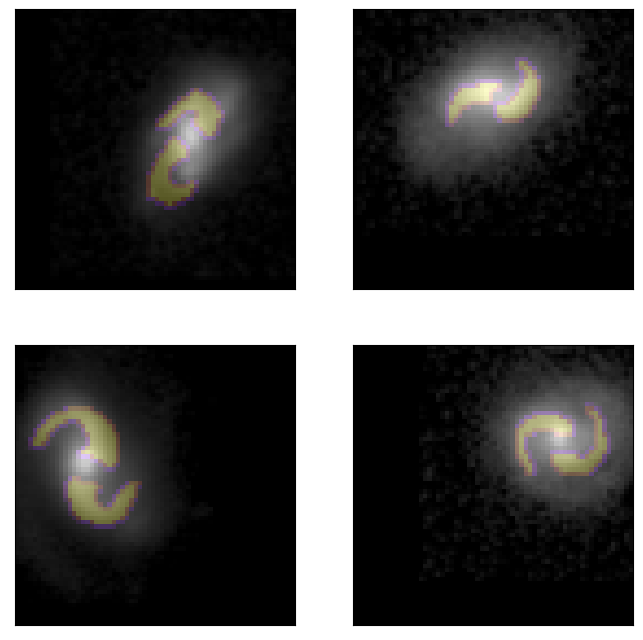

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

for n,(image, mask) in enumerate(train_val_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='gnuplot', alpha=0.2)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## [3] Build Model